In [ ]:
import yfinance as yf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from multiprocessing import Pool, cpu_count
from datetime import datetime
import random

### 8.2.6 EDA in Practice

In this section, we show how we can perform EDA of a set of country ETFs and ACWI. The examples below cover (cross-sectional) summary statistics, histogram plot of an individual ETF, scatter plot of country ETF returns vs. ACWI, PCA implementation and visualization, heatmap for correlation matrix, and t-SNE analysis. Please note that in the book, we present visualizations for the first four ETFs as examples. In this notebook, however, we will work with more ETFs (11 in total).   

**Throughout this notebook, we reuse the DataFrame `df_ret` defined as follows:**

#### Load country EFT and ACWI data

In [ ]:
# load and check country/region ETF data
country_etf_tickers = [
    "EPI",        # India
    "EWC",        # Canada
    "EWG",        # Germany
    "EWH",        # Hong Kong
    "EWJ",        # Japan
    "EWU",        # United Kingdom
    "EWW",        # Mexico
    "EWY",        # South Korea
    "EWZ",        # Brazil
    "FXI",        # China
    "SPY",        # United States
]

df_etf = yf.download(country_etf_tickers, start='2016-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_etf/df_etf.shift(1)).dropna()
df_ret.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,EPI,EWC,EWG,EWH,EWJ,EWU,EWW,EWY,EWZ,FXI,SPY
Date,,,,,,,,,,,
2024-02-22,0.011297,0.009546,0.016358,0.002404,0.016241,0.007324,0.001191,0.012826,-0.005954,0.015145,0.020484
2024-02-23,-0.000899,0.004063,0.000662,-0.003006,0.001595,0.003642,-0.010020,0.000461,-0.011110,0.007073,0.000690
2024-02-26,-0.005185,-0.003792,0.002974,-0.004828,-0.000145,-0.003034,-0.005426,-0.014843,0.005120,-0.008745,-0.003669
2024-02-27,-0.000452,-0.002445,0.007887,0.000000,0.002605,0.000607,-0.000756,-0.009075,0.023454,0.017002,0.001856
2024-02-28,-0.013203,-0.006003,-0.001966,-0.012786,-0.007399,-0.010685,-0.018778,0.008296,-0.021653,-0.036002,-0.001323


In [ ]:
# load and check ACWI data
df_acwi = yf.download('ACWI', start='2016-01-01', end='2024-02-29', auto_adjust=False)[['Adj Close']]
df_acwi_ret = np.log(df_acwi/df_acwi.shift(1)).dropna()
df_acwi_ret.columns = ['Return']
df_acwi_ret.tail()

[*********************100%***********************]  1 of 1 completed


,Return
Date,
2024-02-22,0.017104
2024-02-23,0.000375
2024-02-26,-0.002720
2024-02-27,0.001970
2024-02-28,-0.004227


#### Calculate entire period summary statistics

In [ ]:
pd.DataFrame([df_ret.mean(axis=0)*252, df_ret.std(axis=0)*np.sqrt(252), df_ret.skew(axis=0), df_ret.kurtosis(axis=0)],
             index=['mean','std','skewness','kurtosis'])

Ticker,EPI,EWC,EWG,EWH,EWJ,EWU,EWW,EWY,EWZ,FXI,SPY
mean,0.115093,0.088075,0.046509,0.009789,0.061155,0.041415,0.056898,0.051898,0.110136,-0.021790,0.130810
std,0.216183,0.200212,0.218913,0.192201,0.168922,0.201086,0.258778,0.250782,0.375267,0.274164,0.183570
skewness,-1.124662,-1.192065,-1.031249,-0.379659,-0.609481,-1.480162,-1.117952,-0.791824,-1.256620,0.509739,-0.835101
kurtosis,14.933365,25.049031,13.682017,5.538877,7.989180,19.144171,9.543967,10.773149,14.800826,9.998231,14.162195


#### Calculate rolling summary statistics

In [ ]:
win_size = 2       # 2 years; subject to change

first_win_start_date = df_ret.index.min()
last_win_start_date = df_ret.index.max() - pd.DateOffset(years=win_size)
first_stat_date = df_ret.index.min() + pd.DateOffset(years=win_size)
last_stat_date = df_ret.index.max()

##### 1. Rolling mean

In [ ]:
mean_arr = []
for win_start_date in pd.date_range(first_win_start_date, last_win_start_date, freq='B', inclusive='left'):
      win_end_date = win_start_date + pd.DateOffset(years=win_size)
      win_ret = df_ret.loc[win_start_date:win_end_date]
      win_mean = win_ret.mean(axis=0)
      mean_arr.append(win_mean*252)     # annualization

df_rolling_mean = pd.DataFrame(mean_arr, index=pd.date_range(first_stat_date, last_stat_date, freq='B'))
df_rolling_mean.tail()

Ticker,EPI,EWC,EWG,EWH,EWJ,EWU,EWW,EWY,EWZ,FXI,SPY
2024-02-22,0.133100,0.005671,0.004044,-0.157410,0.048210,0.013160,0.174684,-0.044584,0.100442,-0.193808,0.083640
2024-02-23,0.138496,0.010442,0.012231,-0.155892,0.056251,0.016803,0.174933,-0.038069,0.097259,-0.185835,0.093736
2024-02-26,0.143493,0.015272,0.025247,-0.144065,0.061082,0.021266,0.167425,-0.036395,0.083692,-0.168736,0.099487
2024-02-27,0.147735,0.018792,0.032444,-0.136679,0.066400,0.021161,0.179841,-0.029941,0.082959,-0.163136,0.108670
2024-02-28,0.163766,0.021264,0.044045,-0.134578,0.069439,0.038612,0.188955,-0.021526,0.095740,-0.159744,0.101373


<Axes: >

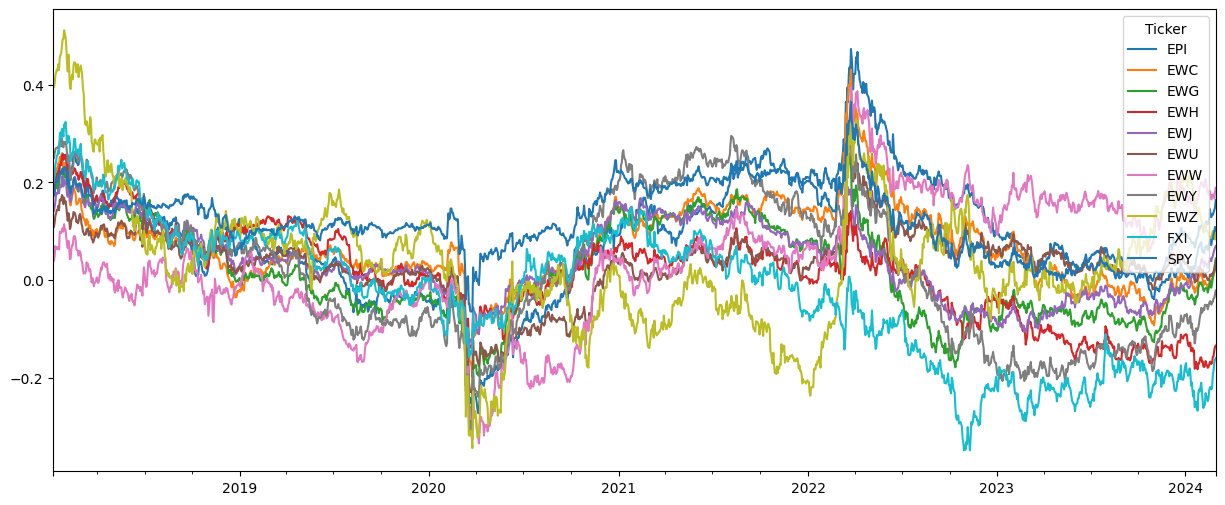

In [ ]:
df_rolling_mean.plot(figsize=(15,6))

##### 2. Rolling standard deviation

In [ ]:
std_arr = []
for win_start_date in pd.date_range(first_win_start_date, last_win_start_date, freq='B', inclusive='left'):
      win_end_date = win_start_date + pd.DateOffset(years=win_size)
      win_ret = df_ret.loc[win_start_date:win_end_date]
      win_std = win_ret.std(axis=0)
      std_arr.append(win_std*np.sqrt(252))     # annualization

df_rolling_std = pd.DataFrame(std_arr, index=pd.date_range(first_stat_date, last_stat_date, freq='B'))
df_rolling_std.tail()

Ticker,EPI,EWC,EWG,EWH,EWJ,EWU,EWW,EWY,EWZ,FXI,SPY
2024-02-22,0.164057,0.199031,0.241729,0.209247,0.173326,0.189599,0.219012,0.249394,0.305127,0.363193,0.190386
2024-02-23,0.164071,0.198947,0.241765,0.209050,0.173526,0.189480,0.218794,0.249316,0.304856,0.363006,0.190731
2024-02-26,0.163874,0.198928,0.241095,0.208242,0.173429,0.189459,0.218904,0.249309,0.304764,0.362567,0.190566
2024-02-27,0.163928,0.199064,0.241121,0.208188,0.173439,0.189648,0.218418,0.249390,0.305066,0.362842,0.190314
2024-02-28,0.162521,0.199232,0.240805,0.208375,0.173560,0.188230,0.218256,0.249356,0.304837,0.363174,0.190225


<Axes: >

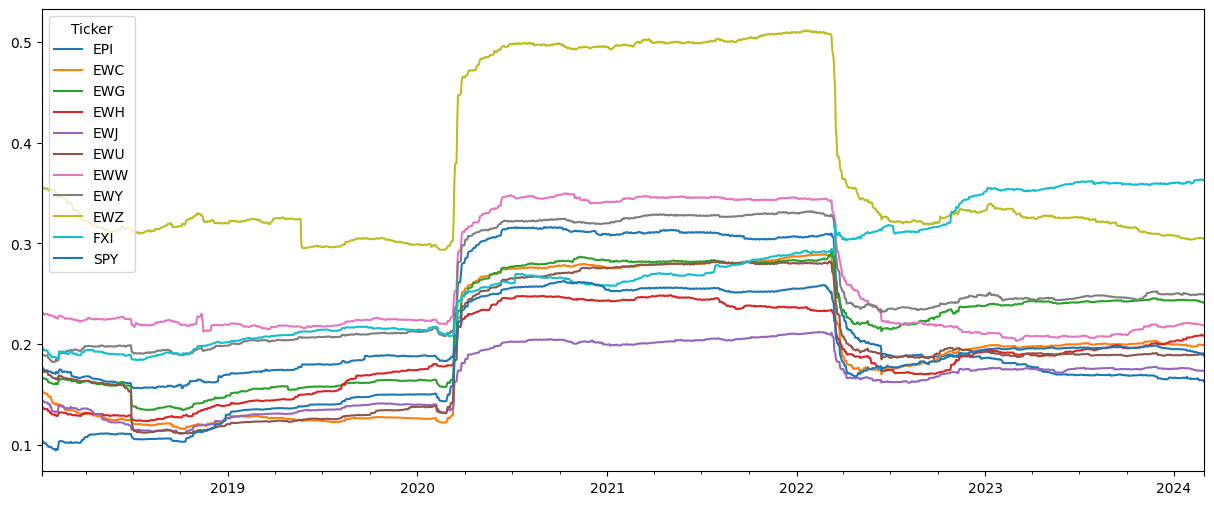

In [ ]:
df_rolling_std.plot(figsize=(15,6))

#### Plot histogram of returns for an individual ETF

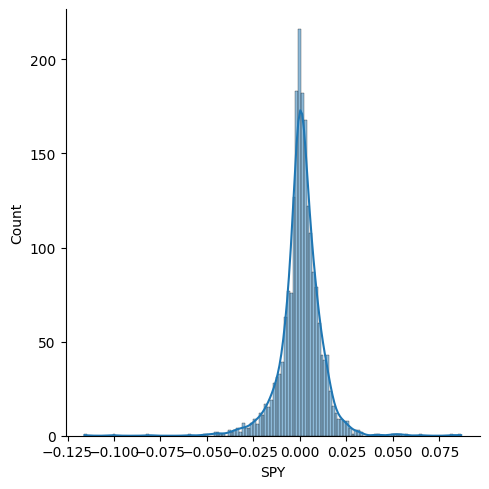

In [ ]:
ticker_name = 'SPY'      # subject to change
sns.displot(df_ret[ticker_name], kde=True)

#### Plot country ETF against ACWI

The following example plots SPY and FXI against ACWI. This type of scatter plot can help us better understand the relationship between the data. For example, SPY fits ACWI much tighter than FXI.

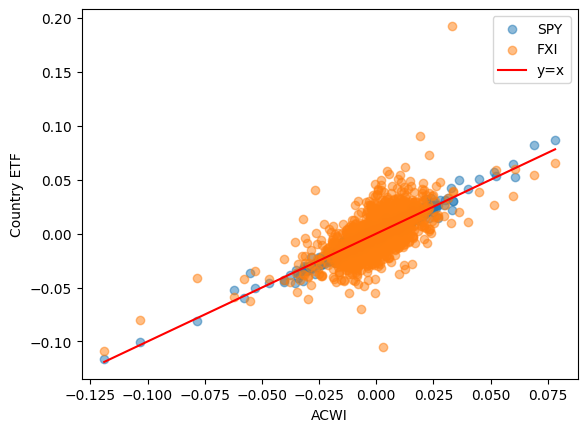

In [ ]:
ticker_name = ['SPY', 'FXI']      # subject to change

for ticker in ticker_name:
    plt.scatter(df_acwi_ret.values, df_ret[ticker].values, label=f'{ticker}', alpha=0.5)
xs = ys = np.linspace(df_acwi_ret.min(), df_acwi_ret.max())
plt.plot(xs, ys, color='r', label='y=x')
plt.xlabel('ACWI')
plt.ylabel('Country ETF')
plt.legend()
plt.show()

#### Visualize correlation matrix
A heatmap of correlation matrix gives more details on relationship among assets.



<Axes: xlabel='Ticker', ylabel='Ticker'>

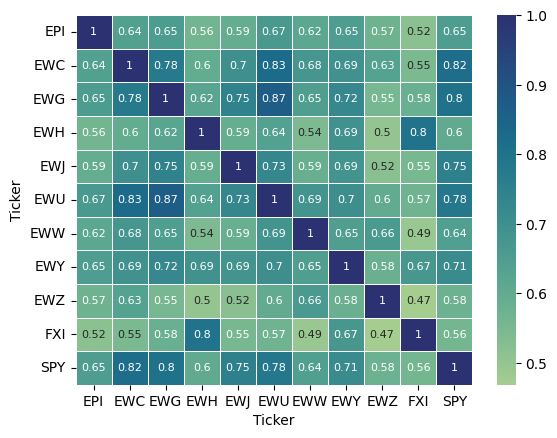

In [ ]:
sns.heatmap(df_ret.corr(), annot=True, linewidth=.5, annot_kws={'fontsize':8}, cmap='crest')

#### PCA

##### 1. PCA implementation and explained variance ratio

In [ ]:
pca = PCA(n_components=5)
X = df_ret.values
pcs = pca.fit_transform(X)

print('Total variance explained by top 5 principal components: {:.2f}%'.format(sum(pca.explained_variance_ratio_)*100))

Total variance explained by top 5 principal components: 90.78%


##### 2. Explained variance ratio against number of PCs

Plotting explained variance against number of principal components (PCs) is a standard way to decide the optimal number of PCs for use. This is a typical use case of the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering). A high-dimensional dataset oftentimes forms an elbow-shaped curve and the turning point is considered the optimal model configuration. Practically, the turning point implies that the gain of model improvement can no longer offset the cost of increasing PCs.

In our example, the country ETF return dataset has $11$ dimensions and is not considered high-dimensional. Still, we can tell from the plot that the rate of increase slows down obviously around $3$ to $5$ PCs. In fact, $5$ PCs can explain more than $90\%$ of the variance.

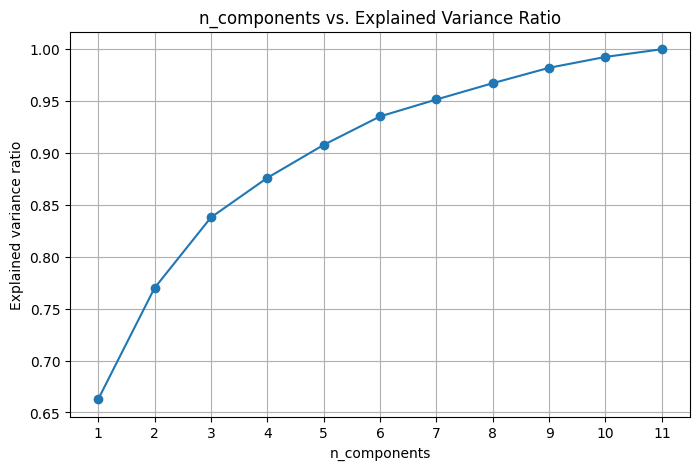

In [ ]:
var_ratio = []
for n in range(1, df_ret.shape[1]+1):
    pca = PCA(n_components=n)
    pca.fit(df_ret)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,5))
plt.grid()
plt.plot(range(1, df_ret.shape[1]+1), var_ratio, marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.xticks(list(range(1,len(country_etf_tickers)+1)))
plt.title('n_components vs. Explained Variance Ratio')
plt.show();

##### 3. Eigenvalue and eigenvector visualization

In the following example, instead of using the PCA function from [sklearn.decomposition](https://scikit-learn.org/stable/api/sklearn.decomposition.html), we manually decompose the covariance matrix, get eigenvalues and eigenvectors, and show how to visualize the top $2$ PCs with corresponding eigenvectors:

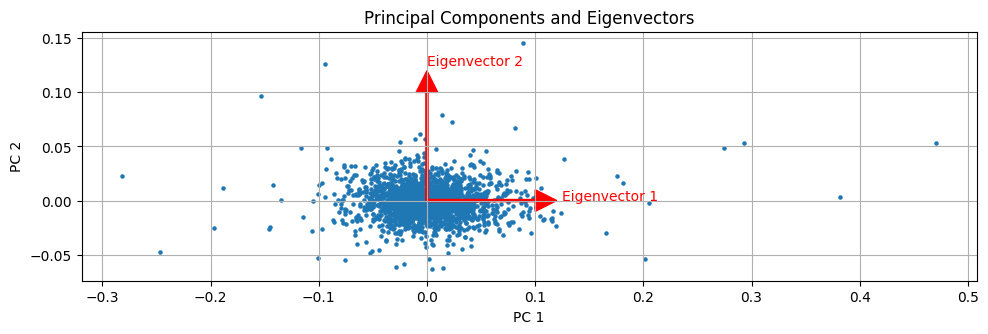

In [ ]:
C = df_ret.cov().values                           # covariance matrix
eigvals, eigvecs = linalg.eigh(C)                 # eigenvalue decomposition
sorted_indices = np.argsort(eigvals)[::-1]        # sort by eigenvalue
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

pcs_proj = np.dot(df_ret.values, eigvecs[:,:2])   # project top 2 pcs to 2D
avg = np.mean(pcs_proj, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(pcs_proj[:,0], pcs_proj[:,1], s=5)

for i in range(2):
    evec = np.dot(eigvecs[:,i], eigvecs[:,:2])    # project the eigenvector corresponding to the i-th pc to 2D
    ax.set_aspect('equal')
    ax.arrow(0, 0, evec[0]/10, evec[1]/10, color='r', width=0.002, head_width=0.02, head_length=0.02)
    ax.text(evec[0]/8, evec[1]/8, f'Eigenvector {i+1}', color='r')

ax.set_title('Principal Components and Eigenvectors')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.grid(True)
plt.tight_layout()
plt.show()

The eigenvectors, as shown above, are always orthogonal to each other.   

We can visualize more PCs in a similar way:

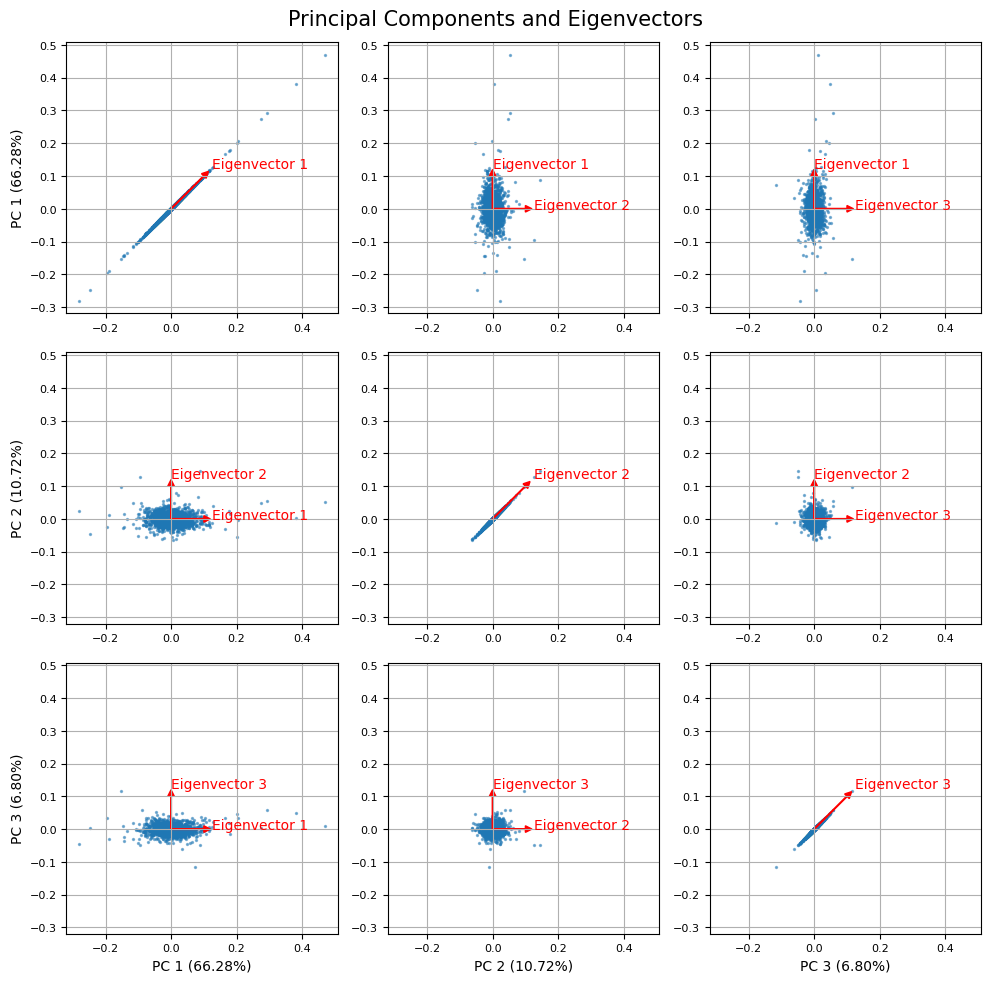

In [ ]:
# visualize 3 pcs
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

for i in range(3):

    for j in range(3):

        if i!=j:
            pcs_proj = np.dot(df_ret.values, eigvecs[:,[i,j]])     # project pcs to 2D
            avg = np.mean(pcs_proj, axis=0)
            axes[j,i].scatter(pcs_proj[:,0], pcs_proj[:,1], s=2, alpha=0.5)

            indices = [i,j]
            for ind in indices:
                evec = np.dot(eigvecs[:,ind], eigvecs[:,[i,j]])    # project eigenvectors to 2D
                axes[j,i].set_aspect('equal')
                axes[j,i].arrow(0, 0, evec[0]/10, evec[1]/10, color='r', width=0.002, head_width=0.02, head_length=0.02)
                axes[j,i].text(evec[0]/8, evec[1]/8, f'Eigenvector {ind+1}', color='r')

        if i==j:
            pcs_proj = np.dot(df_ret.values, eigvecs[:,i])
            avg = np.mean(pcs_proj, axis=0)
            axes[j,i].scatter(pcs_proj, pcs_proj, s=2, alpha=0.5)
            evec = np.dot(eigvecs[:,i], eigvecs[:,i])
            axes[j,i].set_aspect('equal')
            axes[j,i].arrow(0, 0, evec/10, evec/10, color='r', width=0.002, head_width=0.02, head_length=0.02)
            axes[j,i].text(evec/8, evec/8, f'Eigenvector {i+1}', color='r')

        axes[j,i].tick_params(axis='both', which='both', labelsize=8, labelbottom=True, labelleft=True)
        axes[j,i].grid(True)

        if i==0:
            axes[j,i].set_ylabel(f'PC {j+1} ({pca.explained_variance_ratio_[j]*100:.2f}%)')
        if j==2:
            axes[j,i].set_xlabel(f'PC {i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')

plt.suptitle('Principal Components and Eigenvectors', size=15)
plt.tight_layout()
plt.show()

We can also visualize weights of individual country ETFs in the eigenvectors:

In [ ]:
df_eigvecs = pd.DataFrame(-eigvecs, index=df_ret.columns, columns=[f'PC{i+1}' for i in range(len(eigvals))])
df_eigvecs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Ticker,,,,,,,,,,,
EPI,0.261935,-0.041788,0.152733,-0.063833,-0.866237,0.384423,0.032849,0.011405,-0.032718,-0.033795,-0.025948
EWC,0.266967,-0.041100,0.242840,0.187004,0.190857,0.095419,0.400775,-0.579606,-0.103670,-0.330598,-0.413473
EWG,0.289793,-0.175849,0.305384,0.235538,0.161592,0.085077,-0.541641,0.233190,-0.179679,0.314327,-0.473467
EWH,0.230455,-0.249682,-0.290357,-0.035359,0.039151,0.110060,-0.129141,-0.242278,0.817361,0.177524,-0.101864
EWJ,0.205823,-0.124951,0.165309,0.167389,0.074144,-0.087912,0.371488,0.701651,0.316113,-0.371129,-0.073967
EWU,0.270934,-0.103001,0.272972,0.160600,0.177113,0.171809,-0.387856,-0.139197,0.027889,-0.385532,0.659979
EWW,0.329176,0.127881,0.229675,-0.871726,0.227381,0.061214,0.033396,0.066312,-0.013663,0.031216,-0.022574
EWY,0.332938,-0.213794,-0.021396,-0.056855,-0.268996,-0.854254,-0.096078,-0.133756,-0.080130,-0.054080,0.034335
EWZ,0.479502,0.784432,-0.315627,0.219352,0.020360,-0.027860,-0.046327,0.052536,0.007165,0.028903,0.004972


<Axes: xlabel='Ticker'>

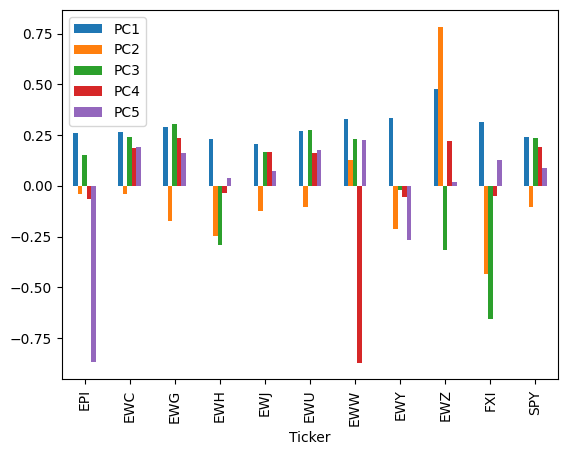

In [ ]:
df_eigvecs.plot.bar(y=['PC1','PC2','PC3','PC4','PC5'])

It's interesting to see that weights in the first eigenvector are of the same sign and similar magnitude. If we take PCs as portfolios, then PC1 is pretty much like the market portfolio, whereas PC2 acts as an EM currency factor.

#### t-SNE

##### 1. t-SNE implementation and clustering

In this example, we start by running the built-in `TSNE` function from [sklearn.manifold](https://scikit-learn.org/stable/api/sklearn.manifold.html):

In [ ]:
X = df_ret.values
tsne = TSNE(n_components=2, verbose=1, perplexity=10, max_iter=1000)     # hyperparameters are subject to change
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2051 samples in 0.009s...
[t-SNE] Computed neighbors for 2051 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2051
[t-SNE] Computed conditional probabilities for sample 2000 / 2051
[t-SNE] Computed conditional probabilities for sample 2051 / 2051
[t-SNE] Mean sigma: 0.007057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.895470
[t-SNE] KL divergence after 1000 iterations: 1.732455


This results in two t-SNE features (as we specified `n_components=2`). Now, we set up a dataframe for t-SNE features, along with a binary label indicating positivity of ACWI returns:

In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['tsne1','tsne2'], index=df_ret.index)
df_tsne['acwi'] = df_acwi_ret.values
df_tsne['is_acwi_pos'] = np.where(df_tsne['acwi']>0, 1, 0)     # create 2 clusters based on ACWI return positivity
df_tsne.tail()

,tsne1,tsne2,acwi,is_acwi_pos
Date,,,,
2024-02-22,28.404545,-42.679344,0.017104,1
2024-02-23,-32.999001,-32.348423,0.000375,1
2024-02-26,-30.507135,32.815350,-0.002720,0
2024-02-27,19.355057,36.652412,0.001970,1
2024-02-28,-65.081924,3.037112,-0.004227,0


We show how to generate a scatter plot that visualizes two clusters defined above:

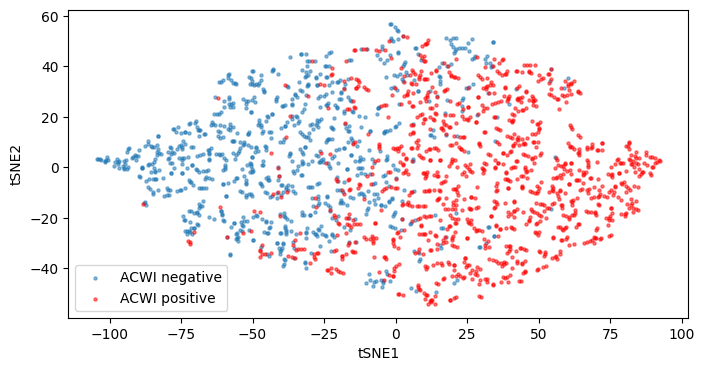

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(df_tsne[df_tsne['is_acwi_pos']==0]['tsne1'], df_tsne[df_tsne['is_acwi_pos']==0]['tsne2'], s=5, alpha=0.5, label='ACWI negative')
ax.scatter(df_tsne[df_tsne['is_acwi_pos']==1]['tsne1'], df_tsne[df_tsne['is_acwi_pos']==1]['tsne2'], c='red', s=5, alpha=0.5, label='ACWI positive')
ax.legend(loc='lower left')
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
plt.show()

We see that the t-SNE features derived from country ETFs are able to separate positive vs. negative ACWI returns. In fact, this is a typical use case of t-SNE visualization that help identify existing clusters by reducing feature dimensions. Of course, we can do clustering with PCA too:

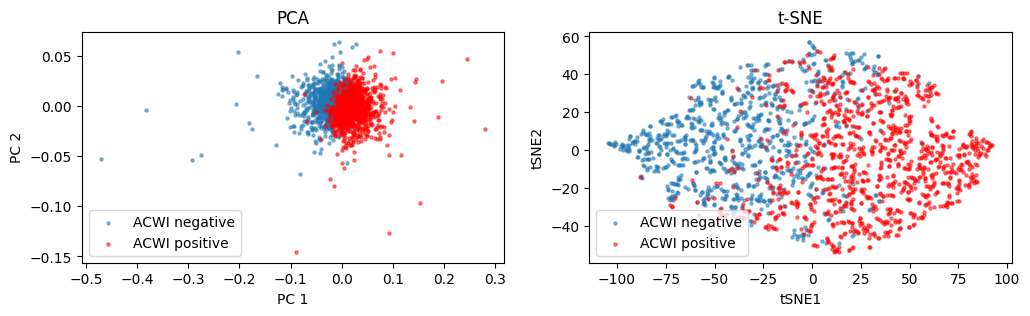

In [ ]:
df_pc = pd.DataFrame(pcs[:,:2], columns=['pc1','pc2'], index=df_ret.index)
df_pc['acwi'] = df_acwi_ret.values
df_pc['is_acwi_pos'] = np.where(df_pc['acwi']>0, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].scatter(df_pc[df_pc['is_acwi_pos']==0]['pc1'], df_pc[df_pc['is_acwi_pos']==0]['pc2'], s=5, alpha=0.5, label='ACWI negative')
axes[0].scatter(df_pc[df_pc['is_acwi_pos']==1]['pc1'], df_pc[df_pc['is_acwi_pos']==1]['pc2'], c='red', s=5, alpha=0.5, label='ACWI positive')
axes[0].legend(loc='lower left')
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].set_title('PCA')

axes[1].scatter(df_tsne[df_tsne['is_acwi_pos']==0]['tsne1'], df_tsne[df_tsne['is_acwi_pos']==0]['tsne2'], s=5, alpha=0.5, label='ACWI negative')
axes[1].scatter(df_tsne[df_tsne['is_acwi_pos']==1]['tsne1'], df_tsne[df_tsne['is_acwi_pos']==1]['tsne2'], c='red', s=5, alpha=0.5, label='ACWI positive')
axes[1].legend(loc='lower left')
axes[1].set_xlabel('tSNE1')
axes[1].set_ylabel('tSNE2')
axes[1].set_title('t-SNE')

plt.show()

t-SNE outputs are highly dependent on hyperparameters. Here we pick one hyperparameter, `perplexity`, to show how the hyperparameter value impacts clustering results. Readers are welcome to try other values and/or other hyperparameters.

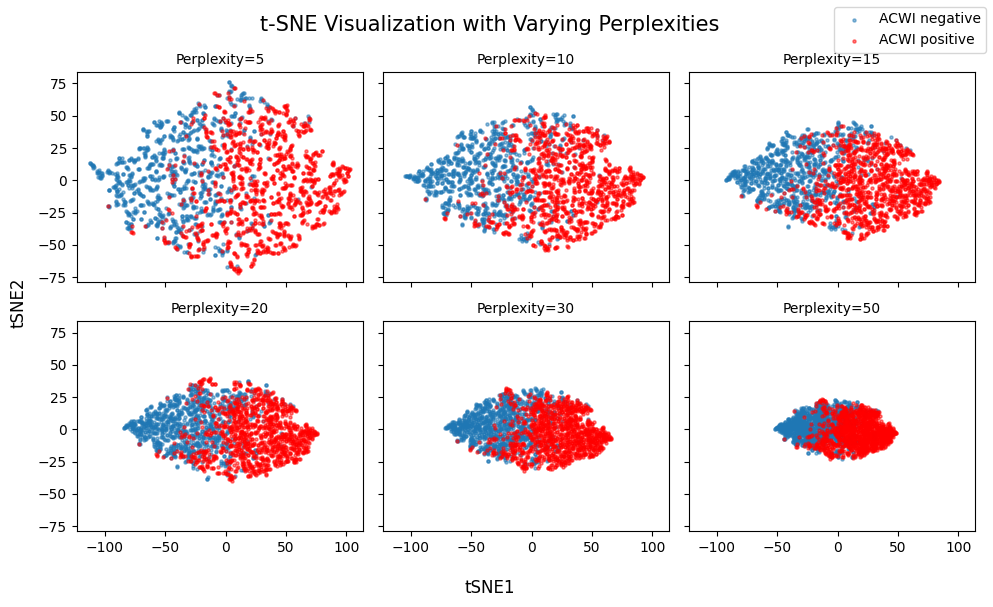

In [ ]:
perplexities = [5,10,15,20,30,50]      # subject to change

fig, axes = plt.subplots(2, 3, figsize=(10,6), sharex=True, sharey=True)

for n, p in enumerate(perplexities):

    i = n//3
    j = n%3

    tsne = TSNE(n_components=2, verbose=0, perplexity=p, max_iter=1000)
    tsne_results = tsne.fit_transform(X)
    df_tsne = pd.DataFrame(tsne_results, columns=['tsne1','tsne2'], index=df_ret.index)
    df_tsne['acwi'] = df_acwi_ret.values
    df_tsne['is_acwi_pos'] = np.where(df_tsne['acwi']>0, 1, 0)

    axes[i,j].scatter(df_tsne[df_tsne['is_acwi_pos']==0]['tsne1'], df_tsne[df_tsne['is_acwi_pos']==0]['tsne2'], s=5, alpha=0.5, label='ACWI negative')
    axes[i,j].scatter(df_tsne[df_tsne['is_acwi_pos']==1]['tsne1'], df_tsne[df_tsne['is_acwi_pos']==1]['tsne2'], c='red', s=5, alpha=0.5, label='ACWI positive')
    axes[i,j].set_title(f'Perplexity={p}', size=10)

labels = [axes[i,j].get_legend_handles_labels() for i in range(2) for j in range(3)]
lines, labels = [sum(lol, []) for lol in zip(*labels)]
unique_labels = set(labels)
legend_dict = dict(zip(labels, lines))
unique_lines = [legend_dict[x] for x in unique_labels]
fig.legend(unique_lines, unique_labels, scatterpoints=1, loc='upper right')

fig.supxlabel('tSNE1')
fig.supylabel('tSNE2')
plt.suptitle('t-SNE Visualization with Varying Perplexities', size=15)
plt.tight_layout()
plt.show()

### 8.5.3 Dimensionality Reduction in Practice: Linear and Non-Linear Approaches to Reduce Dimensionality of a Covariance Matrix

In this coding example, we predict ACWI returns using 1) individual country ETFs, and 2) top 1 PC. We start with linear regression using lagged country ETFs:

In [ ]:
# prepare data
df_data_etf = pd.concat([df_ret.shift(1), df_acwi_ret], axis=1).dropna()
df_data_etf.columns = [f'{c}_lag1' for c in df_ret.columns] + ['ACWI']
df_data_etf.tail()

,EPI_lag1,EWC_lag1,EWG_lag1,EWH_lag1,EWJ_lag1,EWU_lag1,EWW_lag1,EWY_lag1,EWZ_lag1,FXI_lag1,SPY_lag1,ACWI
Date,,,,,,,,,,,,
2024-02-22,-0.009723,-0.001369,0.004385,0.026831,-0.002063,-0.006411,-0.002827,0.000000,0.000000,0.028813,0.000905,0.017104
2024-02-23,0.011297,0.009546,0.016358,0.002404,0.016241,0.007324,0.001191,0.012826,-0.005954,0.015145,0.020484,0.000375
2024-02-26,-0.000899,0.004063,0.000662,-0.003006,0.001595,0.003642,-0.010020,0.000461,-0.011110,0.007073,0.000690,-0.002720
2024-02-27,-0.005185,-0.003792,0.002974,-0.004828,-0.000145,-0.003034,-0.005426,-0.014843,0.005120,-0.008745,-0.003669,0.001970
2024-02-28,-0.000452,-0.002445,0.007887,0.000000,0.002605,0.000607,-0.000756,-0.009075,0.023454,0.017002,0.001856,-0.004227


In [ ]:
# linear regression: ACWI on 11 country ETFs
n = len(df_data_etf)
ntrain = int(n*0.9)       # train-test split

formula_etf = 'ACWI~' + reduce(lambda a, b: a+'+'+b, df_data_etf.columns[:-1])
result_etf = smf.ols(formula=formula_etf, data=df_data_etf.iloc[:ntrain,:]).fit()
print(result_etf.summary())

                            OLS Regression Results                            
Dep. Variable:                   ACWI   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     7.641
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           5.09e-13
Time:                        03:22:00   Log-Likelihood:                 5662.9
No. Observations:                1845   AIC:                        -1.130e+04
Df Residuals:                    1833   BIC:                        -1.124e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.727      0.0

We see some ETFs are statistically significant and some are not. Among those significant ones, SPY is a big factor in ACWI. The signs of coefficients imply a combination of mean reversion and momentum in the market portfolio.

In [ ]:
# prediction
df_pred_etf = df_acwi_ret.copy().iloc[1:]
df_pred_etf['Prediction'] = np.dot(df_data_etf.iloc[:,:-1], result_etf.params[1:]) + result_etf.params.iloc[0]
rmse_train_etf = np.sqrt(mean_squared_error(df_pred_etf['Return'][:ntrain], df_pred_etf['Prediction'][:ntrain]))
rmse_test_etf = np.sqrt(mean_squared_error(df_pred_etf['Return'][ntrain:], df_pred_etf['Prediction'][ntrain:]))
print(f'Train RMSE: {rmse_train_etf:.3f}\nTest RMSE: {rmse_test_etf:.3f}')

Train RMSE: 0.011
Test RMSE: 0.008


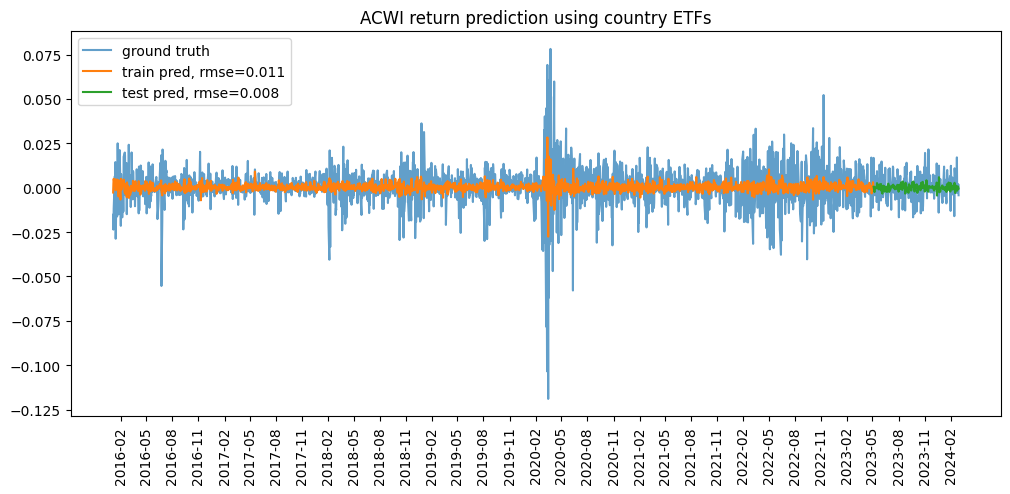

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_pred_etf['Return'], alpha=0.7, label='ground truth')     # ground truth
ax.plot(df_pred_etf['Prediction'][:ntrain], label=f'train pred, rmse={rmse_train_etf:.3f}')     # training set predictions
ax.plot(df_pred_etf['Prediction'][ntrain:], label=f'test pred, rmse={rmse_test_etf:.3f}')       # testing set predictions
ticks_range = pd.date_range(df_pred_etf.index.min(), df_pred_etf.index.max(), freq='3MS', inclusive='both')
plt.xticks(ticks_range, [str(dt.year)+'-'+str('%02d'%dt.month) for dt in ticks_range], rotation=90)
plt.title('ACWI return prediction using country ETFs')
plt.legend()
plt.show()

Now, instead of using all 11 country ETFs, we use the top 1 PC of lag 1 to predict ACWI returns. The steps are pretty similar:

In [ ]:
# prepare data
df_data_pc = pd.concat([df_pc.shift(1)[['pc1']], df_acwi_ret], axis=1).dropna()
df_data_pc.columns = ['pc1_lag1','ACWI']
df_data_pc.tail()

,pc1_lag1,ACWI
Date,,
2024-02-22,0.009980,0.017104
2024-02-23,0.026836,0.000375
2024-02-26,-0.005221,-0.002720
2024-02-27,-0.012218,0.001970
2024-02-28,0.015206,-0.004227


In [ ]:
# linear regression: ACWI on top 1 PC
formula_pc = 'ACWI~pc1_lag1'
result_pc = smf.ols(formula=formula_pc, data=df_data_pc.iloc[:ntrain,:]).fit()
print(result_pc.summary())

                            OLS Regression Results                            
Dep. Variable:                   ACWI   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     36.51
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           1.84e-09
Time:                        03:22:20   Log-Likelihood:                 5639.6
No. Observations:                1845   AIC:                        -1.128e+04
Df Residuals:                    1843   BIC:                        -1.126e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      1.301      0.1

In [ ]:
# prediction
df_pred_pc = df_acwi_ret.copy().iloc[1:]
df_pred_pc['Prediction'] = np.dot(df_data_pc.iloc[:,:-1], result_pc.params[1:]) + result_pc.params.iloc[0]
rmse_train_pc = np.sqrt(mean_squared_error(df_pred_pc['Return'][:ntrain], df_pred_pc['Prediction'][:ntrain]))
rmse_test_pc = np.sqrt(mean_squared_error(df_pred_pc['Return'][ntrain:], df_pred_pc['Prediction'][ntrain:]))
print(f'Train RMSE: {rmse_train_pc:.3f}\nTest RMSE: {rmse_test_pc:.3f}')

Train RMSE: 0.011
Test RMSE: 0.008


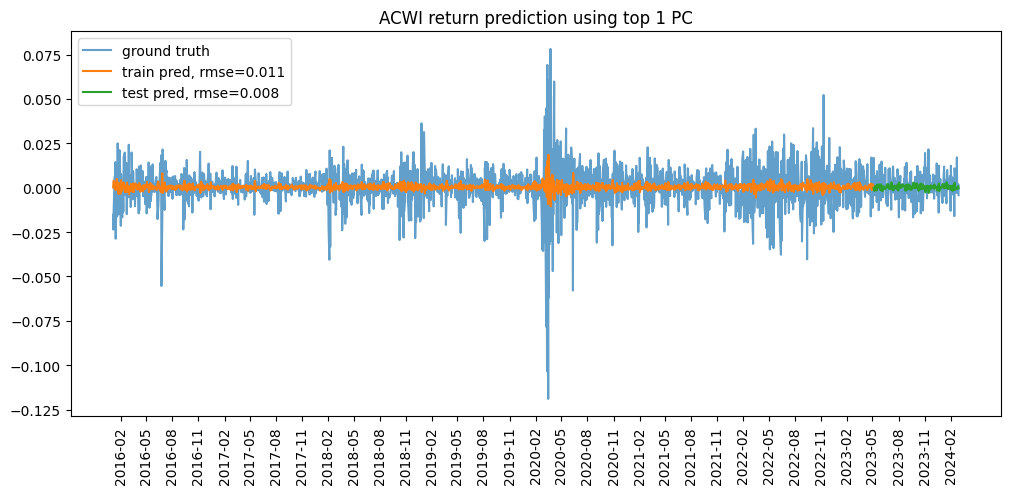

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_pred_pc['Return'], alpha=0.7, label='ground truth')     # ground truth
ax.plot(df_pred_pc['Prediction'][:ntrain], label=f'train pred, rmse={rmse_train_pc:.3f}')     # training set predictions
ax.plot(df_pred_pc['Prediction'][ntrain:], label=f'test pred, rmse={rmse_test_pc:.3f}')       # testing set predictions
ticks_range = pd.date_range(df_pred_pc.index.min(), df_pred_pc.index.max(), freq='3MS', inclusive='both')
plt.xticks(ticks_range, [str(dt.year)+'-'+str('%02d'%dt.month) for dt in ticks_range], rotation=90)
plt.title('ACWI return prediction using top 1 PC')
plt.legend()
plt.show()

Recall that the train and test RMSEs using 11 country ETFs are the same as using PC1 only. Running a regression on all assets can be painful when the portfolio becomes large, and we can simply replace individual assets by top PC(s) to get comparable results.

### 8.6.3 Parallel Computing

Parallel computing can be used in various scenarios, such as bootstrapping and monte carlo simulation. In this example, we simulate $VaR$ for $200$ times through bootstrapping on historical returns (`df_ret`). Please note that this example do NOT require any knowledge on simulation or $VaR$, and function `var_boot()` can be replaced by any user-defined function. Interested readers can refer to the risk management chapter (Chapter 21). We simply hope to provide a use case where parallel computing improves computation efficiency.

This notebook is tested on 2 CPUs. For the sake of running time, we limit the number of simulations to $200$. As we increase the draws, we can see more time benefits.

In [ ]:
def var_boot(df_ret, eps, draws_of_simulation, days_of_silumation):
    '''
    df_ret: dataframe of historical returns
    eps: confidence level
    draws_of_simulation: number of draws simulated from historical returns
    days_of_silumation: number of days of simulation
    '''

    N = df_ret.shape[0]      # number of historical records
    n = df_ret.shape[1]      # number of assets
    ret_simu = np.zeros((draws_of_simulation,n))

    # loop through each draw
    for i in range(draws_of_simulation):

        # randomly pick days_of_silumation out of N historical records
        idx_simu = random.sample(range(N),days_of_silumation)

        # calculate accumulated return over days_of_silumation
        for j in range(days_of_silumation):
            ret_simu[i,:] += df_ret.iloc[idx_simu[j],:]

    df_simu = pd.DataFrame(ret_simu, columns=df_ret.columns)
    df_simu_port = df_simu.mean(axis=1)
    VaR = df_simu_port.quantile(eps)

    return VaR

eps = 0.05
draws_of_simulation = 50  # subject to change
days_of_simulation = 21   # monthly window
nsimulation = 200

In [ ]:
def worker(i):
    return var_boot(df_ret, eps, draws_of_simulation, days_of_simulation)

start_time = datetime.now()

with Pool(processes=cpu_count()) as pool:
    result = pool.map(worker, range(nsimulation), chunksize=1)

end_time = datetime.now()
print(f'Execution time: {end_time-start_time}')

Execution time: 0:00:57.882672


For comparison, we run a for loop without parallel processing:

In [ ]:
start_time = datetime.now()

var_arr = []
for i in range(nsimulation):
    var_arr.append(var_boot(df_ret, eps, draws_of_simulation, days_of_simulation))

end_time = datetime.now()
print(f'Execution time: {end_time-start_time}')

Execution time: 0:01:26.262798


### 8.7.6 Outlier Detection in Practice: Identifying Anomalies in ETF Returns
Here we show how to implement the outlier detection techniques in Python discussed in this section.

In [ ]:
# load and check sample data
df = yf.download(['XLK'], start='2016-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df.tail()

[*********************100%***********************]  1 of 1 completed


Ticker,XLK
Date,
2024-02-22,101.551613
2024-02-23,101.314705
2024-02-26,101.413422
2024-02-27,101.502243
2024-02-28,101.023529


<Axes: xlabel='Date'>

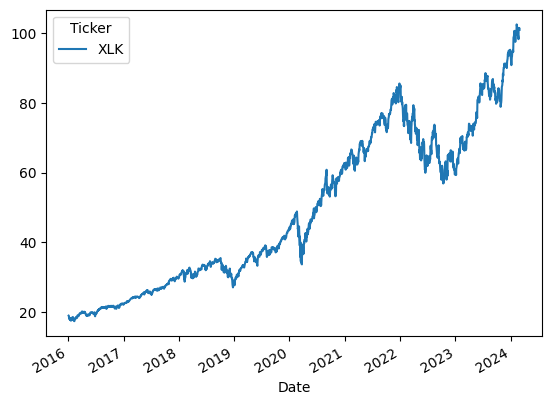

In [ ]:
# plotting
df.plot()

In [ ]:
# standard deviation
df_ret = df.pct_change().dropna()
df_ret.rename(columns={'XLK': 'Return'}, inplace=True)

mean = df_ret['Return'].mean()
std = df_ret['Return'].std()
suspected_outliers = df_ret[(df_ret['Return']<mean-3*std) | (df_ret['Return']>mean+3*std)]
suspected_outliers.tail()

Ticker,Return
Date,
2022-05-05,-0.048096
2022-05-18,-0.045756
2022-09-13,-0.053085
2022-11-10,0.082176
2022-11-30,0.050209


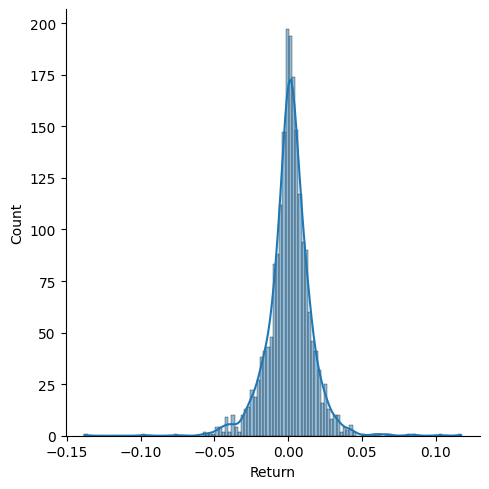

In [ ]:
# density analysis: histogram & density
sns.displot(df_ret['Return'], kde=True)

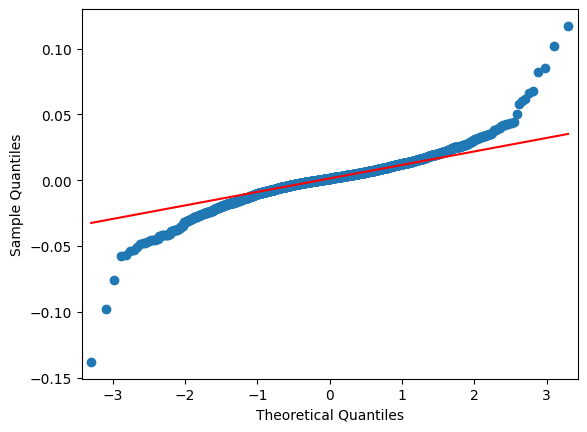

In [ ]:
# density analysis: QQ plot
sm.qqplot(df_ret['Return'], line ='q');

In [ ]:
# density analysis: skewness and kurtosis
print('The skewness of the sample data return is {:.2f}'.format(df_ret['Return'].skew()))
print('The kurtosis of the sample data return is {:.2f}'.format(df_ret['Return'].kurtosis()))

The skewness of the sample data return is -0.21
The kurtosis of the sample data return is 9.21


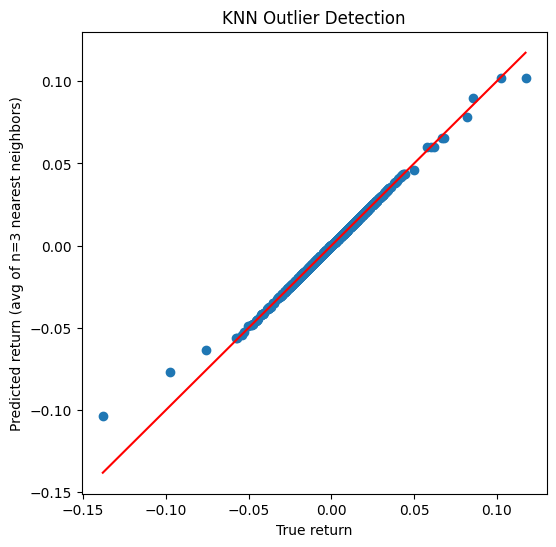

In [ ]:
# KNN
X = df_ret['Return'].values
model = KNeighborsRegressor(n_neighbors = 3)      # n_neighbors is subject to change
model.fit(X.reshape(-1, 1), X)
predictions = model.predict(X.reshape(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(X, predictions)
xs = ys = np.linspace(X.min(), X.max())
plt.plot(xs, ys, color='r')
plt.xlabel('True return')
plt.ylabel('Predicted return (avg of n=3 nearest neighbors)')
plt.title('KNN Outlier Detection')
plt.show()

In [ ]:
# inspect most biased KNN predictions
df_summary = pd.DataFrame({'True': X,
                           'Prediction': predictions,
                           'Error': predictions - X,
                           'Abs Error': np.abs(predictions - X)},
                          index = df_ret.index)
df_summary.sort_values(by=['Abs Error'], ascending=False).head(10)

,True,Prediction,Error,Abs Error
Date,,,,
2020-03-16,-0.138140,-0.103888,0.034252,0.034252
2020-03-12,-0.097605,-0.076956,0.020649,0.020649
2020-03-13,0.117319,0.101685,-0.015634,0.015634
2020-03-09,-0.075920,-0.063419,0.012501,0.012501
2020-04-06,0.085322,0.089971,0.004649,0.004649
2022-11-30,0.050209,0.046086,-0.004122,0.004122
2022-11-10,0.082176,0.078527,-0.003650,0.003650
2020-03-17,0.068082,0.065569,-0.002512,0.002512
2020-03-02,0.057825,0.060049,0.002224,0.002224
